In [1]:
import os
os.chdirrr('..')

In [2]:
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)

from buffers import MultiEnvReplayBuffer
from bnn import BNN
from cem_optimizer_v2 import CEM_opt
from planner_module_v4 import Planner
from lion_opt import Lion

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import torchbnn as bnn
import torch
import tqdm
import json
import random

In [4]:

def json_load():
    with open('config_parameters.json', 'r') as f:
        config_file = json.load(f)
    return config_file


def save_json_update(json_obj):
    with open('config_parameters.json', 'w') as f:
        json.dump(json_obj, f)

config = json_load()


# nested struct
buff_config = config['buffer']
planner_config = config['planner']
const_config = config['const']
train_config = config['train']
'''
i load only the var that i need inside the
traininig loop, not in the initialization of the
object. If each time i should look inside the dict,
i'll consume operation
'''
DEVICE = const_config['DEVICE']
BATCH_SIZE = 256
KL_WEIGHT = train_config['KL_WEIGHT']
EPISODE_FOR_TASK = train_config['EPISODE_FOR_TASK']

In [9]:
#envs_name = list(ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE.keys())
# select best dataset for task : the ones that contains also the solved task, or at least some good performance
envs_name = [
    'button-press-v2-goal-observable',  # rew 9.19
    'button-press-wall-v2-goal-observable',  # rew 8.39, 
    'coffee-button-v2-goal-observable',  # rew 9.26
    'door-close-v2-goal-observable',  # rew 5.83
    'handle-press-v2-goal-observable', # rew 10
    'handle-press-side-v2-goal-observable', #rew 10
    'reach-wall-v2-goal-observable', #rew 10
    'plate-slide-back-v2-goal-observable', # rew 6.99
    'plate-slide-side-v2-goal-observable', # rew 4.46
    'plate-slide-v2-goal-observable', # rew 6.77
    'push-v2-goal-observable', # rew 5.17
    'reach-v2-goal-observable', # rew 10    
]


envs = {}
for name in random.sample(envs_name,  10):
    print(f'selected_env: {name}')
    if not buff_config["correspondence_id2env"].get(name, 0):
        buff_config["correspondence_id2env"][name] = buff_config["correspondence_id2env"]["first_idx_free"]
        buff_config["correspondence_id2env"]["first_idx_free"] += 1
    envs[buff_config["correspondence_id2env"][name]] = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[name]()

config['buffer'] = buff_config
save_json_update(config)



selected_env: push-v2-goal-observable
selected_env: coffee-button-v2-goal-observable
selected_env: plate-slide-v2-goal-observable
selected_env: plate-slide-side-v2-goal-observable
selected_env: button-press-v2-goal-observable
selected_env: button-press-wall-v2-goal-observable
selected_env: reach-wall-v2-goal-observable
selected_env: reach-v2-goal-observable
selected_env: handle-press-v2-goal-observable
selected_env: plate-slide-back-v2-goal-observable


In [120]:
multibuffer = MultiEnvReplayBuffer(
    buffer_size_per_env=10_000
)
multibuffer.read_buffers('buffer_stock/buffer_long/')
for k in envs.keys():
    if multibuffer.elem_for_buffer[k] == 0:
        # if not any sample for that exp: do random move
        print(f'adding random step for model {k}')
        for _ in range(150):   # num ep
            s = envs[k].reset()
            for _ in range(40):  # num step
                act = envs[k].action_space.sample()
                new_s, reward, done, info = envs[k].step(act)
                multibuffer.add(s, act, reward, new_s, done, env_id=k)
                s = new_s

old buffer to load: name: ['buffer_env29.pkl', 'buffer_env26.pkl', 'buffer_env01.pkl', 'buffer_env46.pkl', 'buffer_env35.pkl', 'buffer_env04.pkl', 'buffer_env18.pkl', 'buffer_env36.pkl', 'buffer_env37.pkl', 'buffer_env25.pkl']
processing buffer path : buffer_stock/buffer_long/buffer_env29.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env26.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env01.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env46.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env35.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env04.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env18.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env36.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env37.pkl
processing buffer path : buffer_stock/buffer_long/buffer_env25.pkl
adding random step for model 18
adding random step for model 36
adding random step for model 35
adding 

In [122]:
multibuffer.write_buffer('buffer_stock/buffer_long/')

In [74]:
buffer_test = MultiEnvReplayBuffer(500)

for k in envs.keys():
# fill test buff
    for ep in range(30): 
        s = envs[k].reset()
        for h in range(20):
            a = envs[k].action_space.sample()
            s_prime, rew, done, info = envs[k].step(a)
            buffer_test.add(s, a, rew, s_prime, done, env_id=k)

In [121]:
multibuffer.elem_for_buffer

defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
            {29: 10000,
             26: 10000,
             1: 10000,
             46: 10000,
             35: 10000,
             4: 10000,
             18: 10000,
             36: 10000,
             37: 10000,
             25: 10000})

In [23]:
def train_with_elbo(net, buffer, optimizer, mse_loss, kl_loss, task_id):
    """
   training loop
    """
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=512) if (task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    optimizer.zero_grad()
    x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
    y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
    y_pred = net(x)

    mse = mse_loss(y_pred, y_true)
    kl = kl_loss(net)
    loss = mse + KL_WEIGHT * kl
    loss.backward()
    optimizer.step()
    return mse.item(), kl.item(), loss.item()


def test_with_elbo(net, buffer, mse_loss, kl_loss, task_id):
    """
   test loop
        """
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=512) if (task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    with torch.no_grad():
        
        x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
        y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
        y_pred = net(x)

        mse = mse_loss(y_pred, y_true)
        kl = kl_loss(net)
        loss = mse + KL_WEIGHT * kl
    
    return mse.item(), kl.item(), loss.item()


In [123]:
LR = 1e-4
dynamic = BNN(action_dim=4, obs_dim=39, reward_dim=1).to(DEVICE)
optim = Lion(dynamic.parameters(), lr=LR)
counter_train = 0

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(DEVICE)
mse_loss = torch.nn.MSELoss().to(DEVICE)

In [124]:
mse_history = []
kl_history = []
loss_tot_history = []

mse_history_test = []
kl_history_test = []
loss_tot_history_test = []

In [161]:
env_key = list(envs.keys())[0]
epochs = 1_000
counter_train += epochs

for ep in tqdm.tqdm(range(epochs)):
    
    mse, kl, loss = train_with_elbo(
        net=dynamic,
        buffer=multibuffer,
        optimizer=optim,
        mse_loss=mse_loss,
        kl_loss=kl_loss,
        task_id=-1
    )
    mse_history.append(mse)
    kl_history.append(kl)
    loss_tot_history.append(loss)
    
    mse, kl, loss = test_with_elbo(
        net=dynamic,
        buffer=buffer_test,
        mse_loss=mse_loss,
        kl_loss=kl_loss,
        task_id=-1
    )
    mse_history_test.append(mse)
    kl_history_test.append(kl)
    loss_tot_history_test.append(loss)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.24it/s]


'avg loss for last 500 ep: 0.04046777647361159, counter_train=23000, test_loss last 500 ep: 0.04045571503043175'

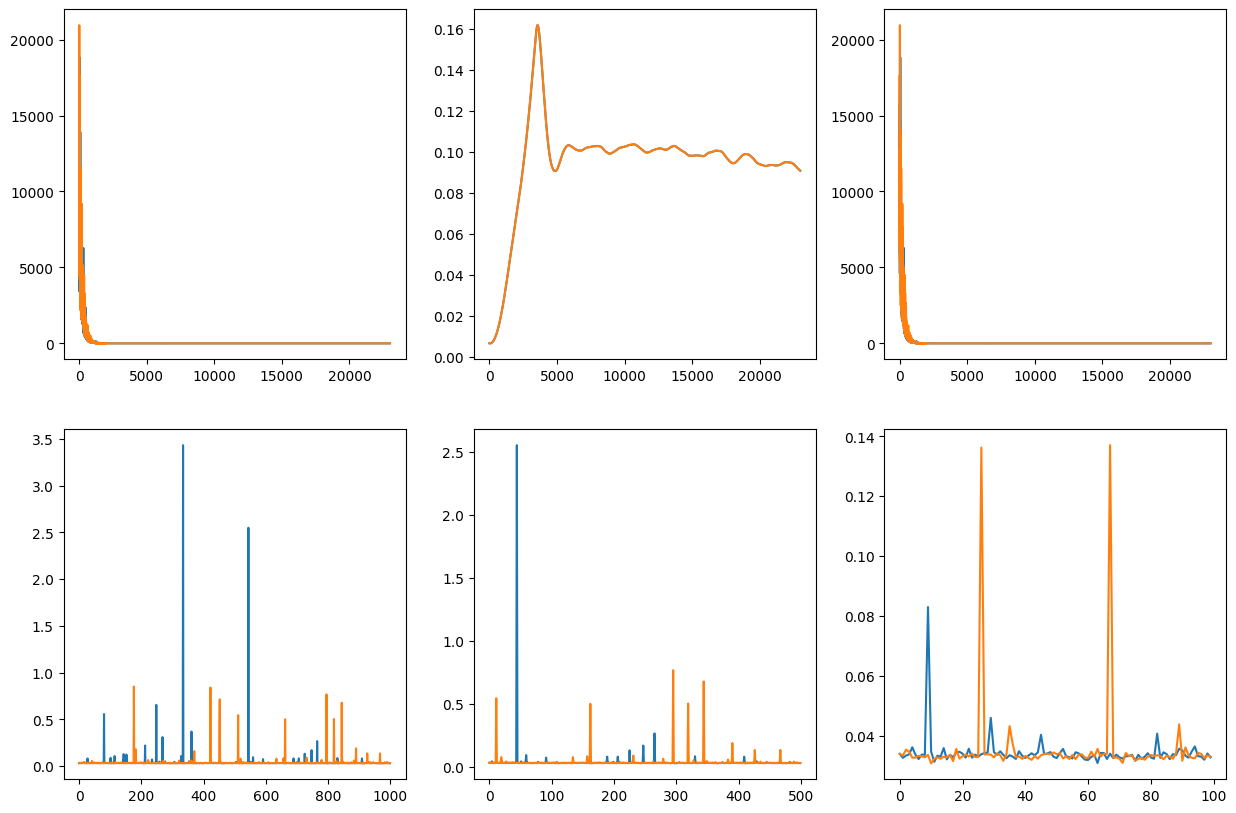

In [162]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].plot(mse_history)
axis[0, 0].plot(mse_history_test)

axis[0, 1].plot(kl_history)
axis[0, 1].plot(kl_history_test)

axis[0, 2].plot(loss_tot_history)
axis[0, 2].plot(loss_tot_history_test)

# zoom
axis[1, 0].plot(mse_history[-1000:])
axis[1, 0].plot(mse_history_test[-1000:])

axis[1, 1].plot(mse_history[-500:])
axis[1, 1].plot(mse_history_test[-500:])

axis[1, 2].plot(mse_history[-100:])
axis[1, 2].plot(mse_history_test[-100:])
f'avg loss for last 500 ep: {sum(loss_tot_history[-500:])/500}, {counter_train=}, test_loss last 500 ep: {sum(loss_tot_history_test[-500:])/500}'


In [11]:
torch.save(dynamic.state_dict(), f'model_stock/dynamic_small_evn_all_lr{LR}_{counter_train}EP.pth')

In [163]:
dyna_specific = BNN(action_dim=4, 
                   obs_dim=39, 
                   reward_dim=1, 
                   weight=dynamic.state_dict()).to(DEVICE)

opt_task = Lion(dyna_specific.parameters(), lr=1e-4)

planner = Planner(
    dyna_specific, 
    num_sequence_action=100, 
    num_particles=40,
    plan_horizon=30
)



In [58]:
env_key

18

In [164]:
history_summed_reward = []
mse_plan_history = []
kl_plan_history = []
loss_plan_history = []

counter_train_specific = 0


In [167]:
EPISODES = 500
BACKPROP_STEP = 5 



old_reward = 0


for ep in range(EPISODES):
    
    clear_output(wait=True)
    
    actual_state = envs[env_key].reset()
    reward_for_ep = []

    
    for step in range(30): # plan horizon 
        best_act = planner.plan_step(actual_state)
        new_state, reward, done, info = envs[env_key].step(best_act)
        
        multibuffer.add(actual_state, best_act, reward, new_state, done, env_key)
        
        actual_state = new_state
        reward_for_ep.append(reward)
        
        
        avg_mse = []
        avg_kl = []
        avg_loss = []
        
        for i in range(BACKPROP_STEP):
       
            counter_train_specific += BACKPROP_STEP
            mse_score, kl_score, tot_loss_score = train_with_elbo(
                net=planner.dynamic,
                optimizer=opt_task,
                buffer=multibuffer,
                mse_loss=mse_loss,
                kl_loss=kl_loss, 
                task_id=env_key
                )    
                
            avg_mse.append(mse_score)
            avg_kl.append(kl_score)
            avg_loss.append(tot_loss_score)

        avg_mse = sum(avg_mse)/len(avg_mse)
        avg_kl = sum(avg_kl)/len(avg_kl)
        avg_loss = sum(avg_loss)/len(avg_loss)
        
        mse_plan_history.append(avg_mse)
        kl_plan_history.append(avg_kl)
        loss_plan_history.append(avg_loss)
        
        print(f'{ep=}| {step=}, [mse, kl, tot]: {avg_mse:.4f} {avg_kl:.4f} {avg_loss:.4f}| reward {reward:.4f}')
        
    
    summed_reward_ep = sum(reward_for_ep)
    print(f'{env_key=} {summed_reward_ep=}, {old_reward=}, {counter_train_specific=} ') 

    old_reward = summed_reward_ep
    history_summed_reward.append(summed_reward_ep)
   

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


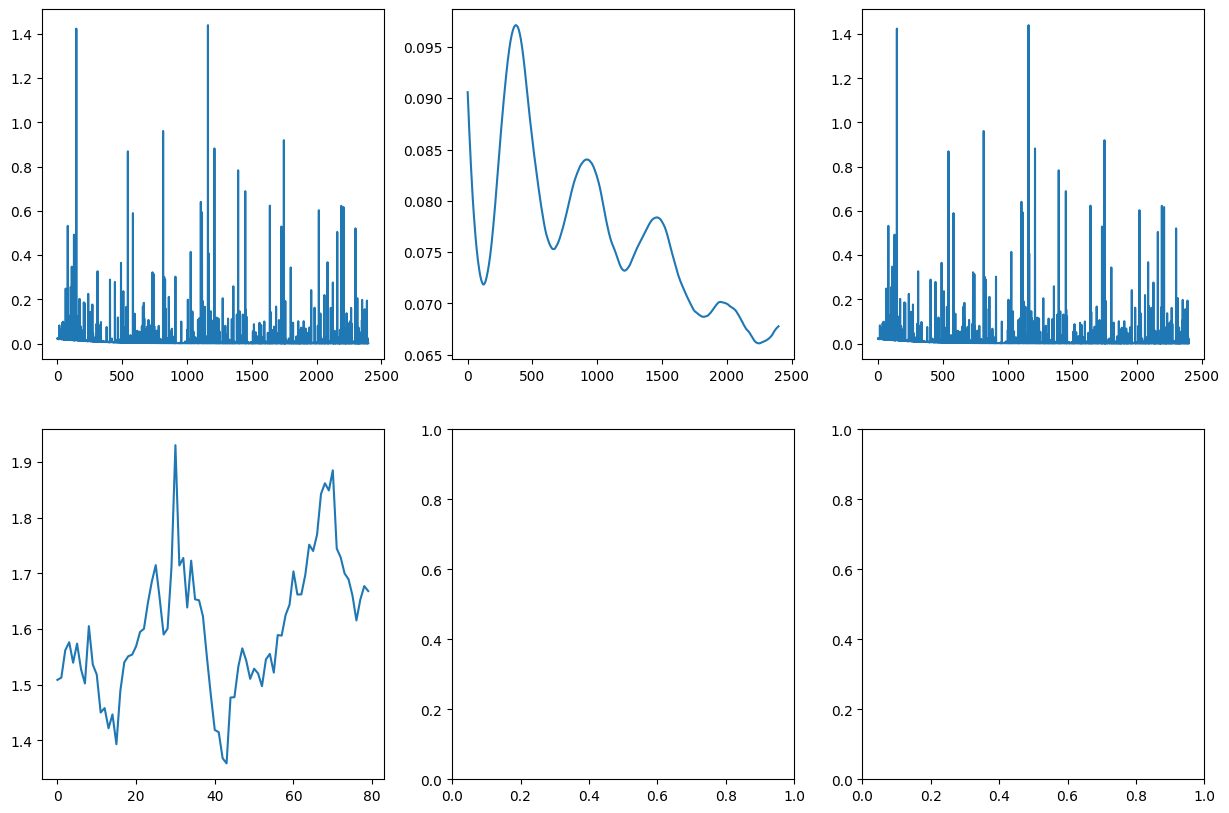

In [166]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].plot(mse_plan_history)
axis[0, 1].plot(kl_plan_history)
axis[0, 2].plot(loss_plan_history)

# zoom
axis[1, 0].plot(history_summed_reward)

In [69]:
multibuffer.elem_for_buffer

defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
            {18: 2000,
             36: 900,
             35: 900,
             4: 900,
             37: 900,
             29: 900,
             25: 900,
             46: 900,
             26: 900,
             1: 900})

In [36]:
import pickle

with open('temp_planner', 'wb') as f:
    pickle.dump(planner, f)

with open('temp_optimizer', 'wb') as f:
    pickle.dump(optimizer, f)
    
